## SRPT vs. BASRPT vs. Random

In [41]:
%load_ext autoreload
import trafpy
import trafpy.generator as tpg

import os
import pickle

DATA_NAME = 'ndf50_mldat6e6_0.4load_university'
path_to_benchmark_data = os.path.dirname(trafpy.__file__)+'/../data/testbed_data/{}_testbed_data.obj'.format(DATA_NAME)
filehandler = open(path_to_benchmark_data, 'rb')
tb_dict = pickle.load(filehandler)

print(tb_dict.keys())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
dict_keys(['benchmark_data', 'benchmarks', 'envs', 'config'])


In [42]:
%autoreload
# unpack env dicts into list of env objects
envs = tb_dict['envs']

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o



-=-=-=-=-=-=--= Summary -=-=-=-=-=-=-=-

 ~* General Information *~
Simulation name: 'benchmark_university_load_0.4_repeat_0_scheduler_srpt'
Measurement duration: 87553.86124985808 (Start time : 10944.23265623226 | End time: 98498.09390609033)
Total number of generated demands (jobs or flows) passed to env: 3000
Total number of these demands which arrived during measurement period: 29
Total info arrived: 208362.0 info unit demands arrived
Total info transported: 29053.0 info unit demands transported
Load (abs): 2.3798150878278683 info unit demands arrived per unit time (from first to last flow arriving)
Load (frac): 0.1983179239856557 fraction of network capacity requested (from first to last flow arriving)
Throughput (abs): 0.33183002537249146 info units transported per unit time
Throughput (frac): 0.13943521371459286 fraction of arrived info successfully transported

 ~* Flow Information *~
Total number of generated flows passed to env (src != dst, dependency_type == 'data_dep'): 3

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

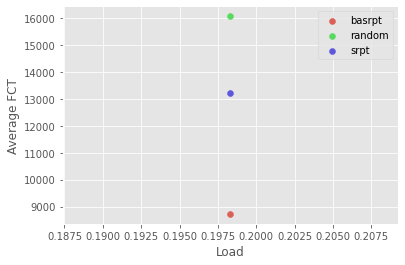

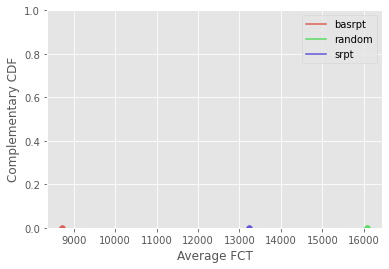

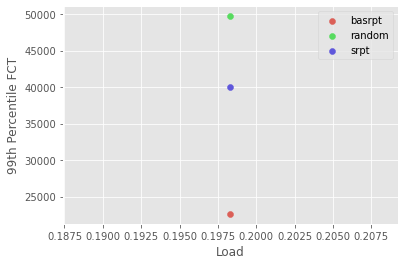

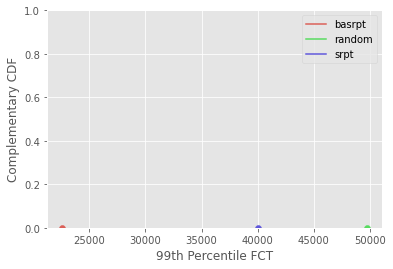

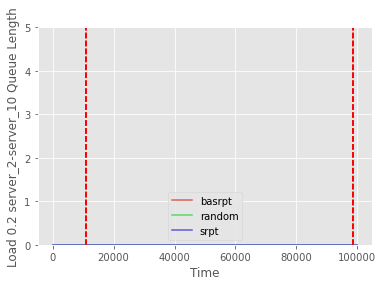

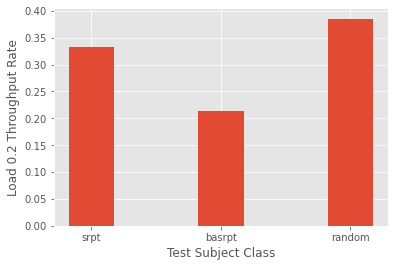

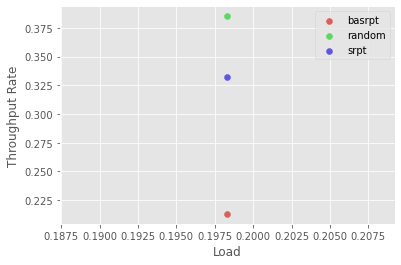

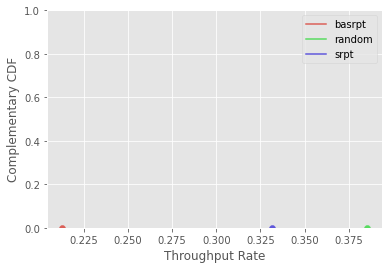

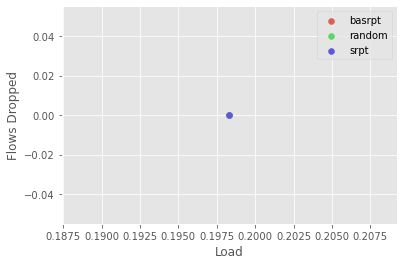

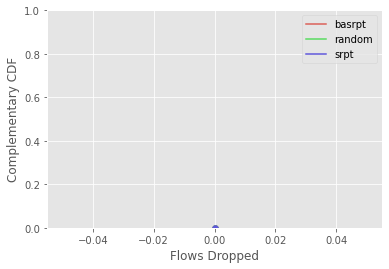

In [43]:
%autoreload
import trafpy
from trafpy.manager import EnvAnalyser, EnvsPlotter

# analyse
analysers = [EnvAnalyser(env, env.scheduler.scheduler_name) for env in envs]
for analyser in analysers:
    analyser.compute_metrics(measurement_start_time='auto',
                             measurement_end_time='auto',
                             print_summary=True)
# plot
plotter = EnvsPlotter()
_ = plotter.plot_average_fct_vs_load(*analysers)
_ = plotter.plot_99th_percentile_fct_vs_load(*analysers)
_ = plotter.plot_src_dst_queue_evolution_for_different_loads('server_2', 'server_10', 'queue_lengths_num_flows', *analysers)
# _ = plotter.plot_src_dst_queue_evolution_for_different_loads('server_2', 'server_10', 'queue_lengths_info_units', *analysers)
_ = plotter.plot_throughput_vs_load(*analysers)
_ = plotter.plot_fraction_of_arrived_flows_dropped_vs_load(*analysers)

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import seaborn as sns

def plot_demand_slot_colour_grid(data, max_time, demand_slots, num_classes, show_figure=False):

    # set colours
    class_colours = sns.color_palette(palette='hls', n_colors=num_classes, desat=None)
    cmap = colors.ListedColormap(class_colours)
    # cmap=None

    # plot grid
    fig, ax = plt.subplots()
    c = ax.pcolor(Z, cmap=cmap)

    plt.xlabel('Time')
    plt.ylabel('Flow Slot')

    plt.show()

srpt
Num time points: 12
Times: [0, 10000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 80000.0, 90000.0, 100000.0]
Demands: [None, None, None, 'flow_5', 'flow_4', None, None, None, 'flow_26', 'flow_9', None, None]
Demands info: [None, None, None, {'flow_id': 'flow_5', 'size': 68.0, 'src': 'server_0', 'dst': 'server_3', 'establish': 1, 'parent_deps': None, 'completed_parent_deps': [], 'child_deps': None, 'parent_op_run_time': None, 'time_parent_op_started': None, 'parent_op': None, 'dependency_type': None, 'child_op': None, 'can_schedule': 1, 'job_id': None, 'path': ['server_0', 'rack_0', 'edge_0', 'rack_1', 'server_3'], 'channel': 'channel_1', 'packets': array([300.]), 'time_arrived': 22547.847315588268, 'time_completed': None, 'k_shortest_paths': [['server_0', 'rack_0', 'edge_0', 'rack_1', 'server_3']]}, {'flow_id': 'flow_4', 'size': 667.0, 'src': 'server_10', 'dst': 'server_0', 'establish': 1, 'parent_deps': None, 'completed_parent_deps': [], 'child_deps': None, 

/home/cwfparsonson/anaconda3/envs/deep_scheduler/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


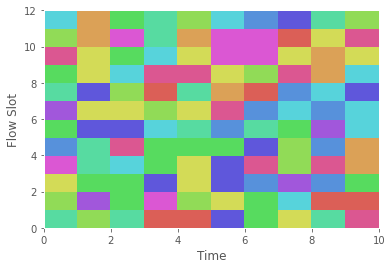

In [47]:
env = envs[0]
print(env.scheduler.scheduler_name)

# print(env.grid_slot_dict)
grid_demands = []
for ep in env.grid_slot_dict.keys():
    for channel in env.grid_slot_dict[ep].keys():
        grid_demands.append(env.grid_slot_dict[ep][channel]['demands'])
        print('Num time points: {}'.format(len(env.grid_slot_dict[ep][channel]['times'])))
        print('Times: {}'.format(env.grid_slot_dict[ep][channel]['times']))
        print('Demands: {}'.format(env.grid_slot_dict[ep][channel]['demands']))
        print('Demands info: {}'.format(env.grid_slot_dict[ep][channel]['demands_info']))
grid_demands = np.array([np.array(xi) for xi in grid_demands])

# conv grid demands to integer ids
unique_id_counter = 0
demand_to_id = {}
for slot_idx in range(len(grid_demands)):
#     print('Length of slot time array: {}'.format(len(grid_demands[slot_idx])))
#     print('Times: {}'.format(grid_demands[slot_idx]))
    for time_idx in range(len(grid_demands[slot_idx])):
        d = grid_demands[slot_idx][time_idx]
        if d not in demand_to_id.keys():
            # not yet encountered demand, update demand_to_id dict
            demand_to_id[d] = unique_id_counter
            unique_id_counter += 1
            # update grid_demands
            grid_demands[slot_idx][time_idx] = demand_to_id[d]
        else:
            # update grid_demands
            grid_demands[slot_idx][time_idx] = demand_to_id[d]
            
print('demand to id:\n{}'.format(demand_to_id))

print(grid_demands.shape)
print(type(grid_demands))
print(type(grid_demands[0]))
print(grid_demands)





# define data
max_time = 10
flow_slots = 12
num_classes = 12

Z = np.random.rand(flow_slots, max_time) * num_classes
Z = Z.astype(int)
print(Z.shape)
print(type(Z))
print(type(Z[0]))
print(Z)

# plot
plot_demand_slot_colour_grid(Z, max_time=max_time, demand_slots=flow_slots, num_classes=num_classes, show_figure=True)

In [55]:
edges = env.network.edges
print(edges)

[('core_0', 'agg_0'), ('core_0', 'agg_1'), ('core_0', 'agg_2'), ('core_1', 'agg_0'), ('core_1', 'agg_1'), ('core_1', 'agg_2'), ('rack_0', 'edge_0'), ('rack_0', 'server_0'), ('rack_0', 'server_1'), ('rack_1', 'edge_0'), ('rack_1', 'server_2'), ('rack_1', 'server_3'), ('rack_2', 'edge_1'), ('rack_2', 'server_4'), ('rack_2', 'server_5'), ('rack_3', 'edge_1'), ('rack_3', 'server_6'), ('rack_3', 'server_7'), ('rack_4', 'edge_2'), ('rack_4', 'server_8'), ('rack_4', 'server_9'), ('rack_5', 'edge_2'), ('rack_5', 'server_10'), ('rack_5', 'server_11'), ('edge_0', 'agg_0'), ('edge_1', 'agg_1'), ('edge_2', 'agg_2')]
